# MNIST beseline in python
Этот пример я буду использовать для реализации такой же нейросети на языке Go, поэтому здесь не будет многих оптимизаций, которые я не смогу реализовать на другом языке, такие как:
* Работа с GPU
* Оптимизатор ADAM
* Распараллеливание даталоадеров

Также я буду использовать архитектуру из видео с канала 3blue1brown для воспроизводимости. Отличия от современных архитектур:
* Сигмоида в качестве активации
* MSE в качестве лосса

Всё это делает написание кода и вычисление производной немного проще, что и дает возможность реализовать это самому без сторонних библиотек

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
train_ds = MNIST(root='data/',train=True,transform=transforms.ToTensor(),download=True)
val_ds = MNIST(root='data/',train=False,transform=transforms.ToTensor(),download=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36273694.19it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1054050.45it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10081459.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2335482.26it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_dl = DataLoader(dataset=train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(dataset=val_ds, batch_size=64, shuffle=False)

## Реализуем архитектуру из видео 3blue1brown

In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.propagate = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.propagate(x)
        return logits

In [5]:
MSE = nn.MSELoss()
def loss(inp,target):
    # return ((inp - nn.functional.one_hot(target,10))**2).mean()
    target = nn.functional.one_hot(target,10).float()
    return MSE(inp,target)

In [6]:
model = SimpleNN()
optimizer = torch.optim.SGD(model.parameters(), lr=5.0)

## Обучение

In [7]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = {"train_loss": [], "val_loss": []}

    for epoch in tqdm(range(epochs)):
        avg_train_loss = 0
        avg_val_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch,Y_batch
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred,Y_batch)
            loss.backward()
            opt.step()
            avg_train_loss += loss / len(data_tr)
        
        # print(f"train loss: {avg_train_loss}")  
        history["train_loss"].append(avg_train_loss.detach().cpu().numpy())
        
        model.eval()
        correct = 0
        total = 0
        for X_batch, Y_batch in data_val:
            X_batch, Y_batch = X_batch,Y_batch
            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred,Y_batch)
                _, predicted = torch.max(Y_pred, dim=1)
                total += Y_batch.size(0)
                correct += (predicted == Y_batch).sum().item()
                
            avg_val_loss += loss / len(data_val)
        print(f'Accuracy: {100 * correct / total}%')
        # print(f"val loss: {avg_val_loss}")        
        history["val_loss"].append(avg_val_loss.detach().cpu().numpy())
    return history

In [8]:
max_epochs = 25
history = train(model, optimizer, loss, max_epochs, train_dl, val_dl)

  0%|          | 0/25 [00:00<?, ?it/s]

Accuracy: 30.11%
Accuracy: 76.67%
Accuracy: 88.95%
Accuracy: 90.67%
Accuracy: 91.59%
Accuracy: 92.2%
Accuracy: 92.69%
Accuracy: 92.88%
Accuracy: 93.15%
Accuracy: 93.35%
Accuracy: 93.38%
Accuracy: 93.82%
Accuracy: 93.89%
Accuracy: 93.93%
Accuracy: 94.0%
Accuracy: 94.16%
Accuracy: 94.37%
Accuracy: 94.11%
Accuracy: 94.17%
Accuracy: 94.5%
Accuracy: 94.47%
Accuracy: 94.57%
Accuracy: 94.58%
Accuracy: 94.65%
Accuracy: 94.65%


In [9]:
def draw_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"],label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

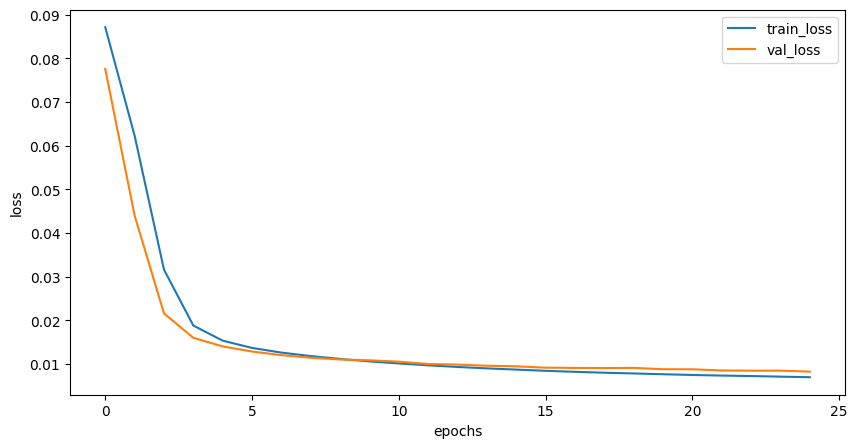

In [10]:
draw_history(history)

In [11]:
def validate(model, data_val):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inp, target in data_val:
            output = model(inp)
            _, predicted = torch.max(output, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

In [12]:
validate(model, val_dl)

Accuracy: 94.65%
